Merging the Data and Storing in a Database/Visualizing Data
Now that you have cleaned and transformed your 3 datasets, you need to load them into a
database. You can choose what kind of database (SQLLite or MySQL, Postgre SQL are all free
options). You will want to load each dataset into SQL Lite as an individual table and then you
must join the datasets together in Python into 1 dataset.
Once all the data is merged together in your database, create 5 visualizations that demonstrate
the data you have cleansed. You should have at least 2 visualizations that have data from more
than one source (meaning, if you have 3 tables, you must have visualizations that span across 2
of the tables – you are also welcome to use your consolidated dataset that you created in the
previous step, if you do that, you have met this requirement).

Submit your code for merging and storing in the database, with your code for the visualizations
along with a 250-500-word summary of what you learned and had to do to complete the
project. You can submit a Jupyter Notebook or a PDF of your code. If you submit a .py file you
need to also include a PDF or attachment of your results.

In [203]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import quandl
import json
import datetime as dt

In [23]:
# Loading the Financial history data
# reusing the earlier database db_dsc540 for the final project
# Opening a connection object to connect to the database
with sqlite3.connect('db_dsc540') as conn:

    yr = ['2014','2015','2016','2017','2018']
    for i in range(5):
        yr[i]
        filename = "data/" + yr[i] +"_Financial_Data.csv"

        # defining the list of columns to load to the database
        column = ['Unnamed: 0','Revenue','Gross Profit','Operating Expenses','Operating Income','Interest Expense',
                 'Earnings before Tax','Net Income','EPS','Dividend per Share','Gross Margin','EBITDA',
                 'Revenue per Share','Net Income per Share','Market Cap','PE ratio','Price to Sales Ratio',
                 'Debt to Equity','Debt to Assets','Sector']
        df_fin_hist = pd.read_csv(filename, usecols=column)
        # Changing / Replace a column name in the dataframe
        df_fin_hist.rename(columns={'Unnamed: 0': 'Ticker'},inplace = True)
        df_fin_hist.insert(0, 'Year', yr[i])
        df_fin_hist.columns = [column.replace(' ','_') for column in df_fin_hist.columns]
        # write to the existing database into a new table
        df_fin_hist.to_sql('FinancialIndicator',conn, if_exists='append',index=False)
    # df_fin_hist.shape
    # df_fin_hist.head()


In [98]:
with sqlite3.connect('db_dsc540') as conn:
    list_of_ticker = ['AAPL','AMZN','LULU','BAC','T']
    for i in range(5):
        TK = list_of_ticker[i]
        print("Inserting Ticker",TK)
        url = "https://finance.yahoo.com/quote/" + TK + "/history?period1=1571443200&period2=1603065600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
        resp = requests.get(url)
        soup = BeautifulSoup(resp.text, 'html.parser')
        data = soup.findAll('tr')
        headers = data[0]
        data_without_header = data[1:]
        col_headers = [th.getText() for th in headers.findAll('th')]
        df_url_data = [[td.getText() for td in tr.findAll('td')] for tr in data_without_header]
        df_eod_with_header = pd.DataFrame(df_url_data, columns=col_headers)
        df_eod_with_header.insert(0,'Ticker', TK)
        # remove the last row as it is the footer.
        df_eod_no_footer = df_eod_with_header[:-1]

        df_eod_no_footer.columns = [column.replace('*','') for column in df_eod_no_footer.columns]

        # write to the existing database into a new table
        df_eod_no_footer.to_sql('eodstockprice',conn, if_exists='append',index=False)

Inserting Ticker AAPL


/home/samantoz/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


Inserting Ticker AMZN
Inserting Ticker LULU
Inserting Ticker BAC
Inserting Ticker T


In [119]:
# Open the quandlAPI.json file to read the api key
with open('quandlAPI.json') as f:
    keys = json.load(f)
    quandlapi = keys['api_key']

quandl.ApiConfig.api_key = quandlapi
# Loading the data from the API into a pandas dataframe
start = dt.date(2020,10,31)
end = dt.date(2020,10,31)
# data = quandl.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31")
# data_aapl_tsp = quandl.get("WIKI/AAPL", rows=10)
# creating a list of tickers to be extracted using the API
list_of_ticker = ['AAPL','AMZN','TSLA']
for i in range(len(list_of_ticker)):
    TK = list_of_ticker[i]
    # print(quandl.get('WIKI/'+TK, start_date=start, end_date=end))
    tmp_data = quandl.get('WIKI/'+TK, start_date=start, end_date=end)
    # Replace header to add the Ticker symbols for each stock
    tmp_data.insert(0,'Ticker', TK)
    df_api = df_api.append(tmp_data)

# df_data = pd.DataFrame(df_data_comb) 
# df.shape
# df.tail()
# tmp_data.head

NameError: name 'df_api' is not defined

In [121]:
tmp_data.head

<bound method NDFrame.head of Empty DataFrame
Columns: [Ticker, Open, High, Low, Close, Volume, Ex-Dividend, Split Ratio, Adj. Open, Adj. High, Adj. Low, Adj. Close, Adj. Volume]
Index: []>

In [63]:
# df_eod['Volume'] = df_eod['Volume'].str.replace(',', '').astype(float)
# df_eod[["Open","High","Low","Close*","Adj Close**"]] = df_eod[["Open","High","Low","Close*","Adj Close**"]].apply(pd.to_numeric) 
# df_eod[["Open","High"]] = df_eod[["Open","High"]].apply(pd.to_numeric) 

df_eod_no_footer.dtypes

Ticker       object
Date         object
Open         object
High         object
Low          object
Close        object
Adj Close    object
Volume       object
dtype: object

In [65]:
df_eod_no_footer.describe()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
count,100,100,100,98,98,98,98,98
unique,1,98,99,95,97,97,97,98
top,AAPL,"Aug 31, 2020",110.40,99.25,110.00,91.03,90.71,"332,607,200"
freq,100,2,2,2,2,2,2,1


In [62]:
# Writing the SQL statements
cursor = conn.cursor()
sql_stmt = ''' select * from sqlite_master'''
rows = cursor.execute(sql_stmt)
for row in rows:
    print(row)

('table', 'customer', 'customer', 2, 'CREATE TABLE "customer" (\n\t"cust_name"\tTEXT NOT NULL,\n\t"cust_address"\tTEXT,\n\t"cust_city"\tTEXT,\n\t"cust_state"\tTEXT,\n\t"cust_zip"\tTEXT,\n\t"cust_phone"\tINTEGER\n)')
('table', 'FinancialIndicator', 'FinancialIndicator', 3, 'CREATE TABLE "FinancialIndicator" (\n"Ticker" TEXT,\n  "Revenue" REAL,\n  "Gross_Profit" REAL,\n  "Operating_Expenses" REAL,\n  "Operating_Income" REAL,\n  "Interest_Expense" REAL,\n  "Earnings_before_Tax" REAL,\n  "Net_Income" REAL,\n  "EPS" REAL,\n  "Dividend_per_Share" REAL,\n  "Gross_Margin" REAL,\n  "EBITDA" REAL,\n  "Revenue_per_Share" REAL,\n  "Net_Income_per_Share" REAL,\n  "Market_Cap" REAL,\n  "PE_ratio" REAL,\n  "Price_to_Sales_Ratio" REAL,\n  "Debt_to_Equity" REAL,\n  "Debt_to_Assets" REAL,\n  "Sector" TEXT\n)')
('table', 'eodstockprice', 'eodstockprice', 5, 'CREATE TABLE "eodstockprice" (\n"Ticker" TEXT,\n  "Date" TEXT,\n  "Open" REAL,\n  "High" REAL,\n  "Low" REAL,\n  "Close" REAL,\n  "Adj Close" REAL,\

In [99]:
# Reading from a sql query into a pandas dataframe 
sql_stmt = """select Ticker, count(*) from eodstockprice group by Ticker"""
with sqlite3.connect('db_dsc540') as conn:
    df_eod = pd.read_sql_query(sql_stmt,conn)

In [100]:
df_eod.shape

(5, 2)

In [101]:
df_eod.head

<bound method NDFrame.head of   Ticker  count(*)
0   AAPL       100
1   AMZN       100
2    BAC       100
3   LULU       100
4      T       100>

In [88]:
conn.close()

In [39]:
# Reading the data from the table
pd.read_sql_query('SELECT count(*) from FinancialIndicator',conn)

ProgrammingError: Cannot operate on a closed database.

In [10]:
# sample each Ticker from this table
pd.read_sql_query('''SELECT Ticker,count(*) from FinancialIndicator 
                  group by Ticker
                  ''',conn)

,Ticker,count(*)
0,A,1
1,AA,1
2,AABA,1
3,AAL,1
4,AAMC,1
...,...,...
4387,ZTR,1
4388,ZTS,1
4389,ZUMZ,1
4390,ZYME,1


In [12]:
# Show the Financial data for the following five companies by Ticker symbol
pd.read_sql_query('''SELECT * from FinancialIndicator 
                  where Ticker in ('AAPL','AMZN','LULU','BAC','T')
                  ''',conn)

,Ticker,Revenue,Gross_Profit,Operating_Expenses,Operating_Income,Interest_Expense,Earnings_before_Tax,Net_Income,EPS,Dividend_per_Share,Gross_Margin,EBITDA,Revenue_per_Share,Net_Income_per_Share,Market_Cap,PE_ratio,Price_to_Sales_Ratio,Debt_to_Equity,Debt_to_Assets,Sector
0,BAC,9.124700e+10,9.124700e+10,5.338100e+10,3.786600e+10,0.000000e+00,3.458400e+10,2.814700e+10,2.64,0.54,1.0000,3.664700e+10,9.0375,2.7878,2.418218e+11,9.3333,2.6502,1.6454,0.1854,Financial Services
1,AAPL,2.655950e+11,1.018390e+11,3.094100e+10,7.089800e+10,0.000000e+00,7.290300e+10,5.953100e+10,12.01,2.72,0.3834,8.380600e+10,53.5973,12.0134,1.097649e+12,18.9226,4.1328,1.0685,0.3130,Technology
2,T,1.707560e+11,9.133700e+10,6.524100e+10,2.609600e+10,7.957000e+09,2.429000e+10,1.937000e+10,2.85,2.00,0.5349,6.067700e+10,23.4619,2.6614,2.077141e+11,10.0140,1.2164,0.9588,0.3319,Communication Services
3,AMZN,2.328870e+11,9.373100e+10,8.131000e+10,1.242100e+10,1.417000e+09,1.127000e+10,1.007300e+10,20.68,0.00,0.4025,2.802800e+10,478.2074,20.6838,7.344162e+11,72.6291,3.1535,0.7611,0.2038,Technology
4,LULU,2.649181e+09,1.398790e+09,9.427890e+08,4.560010e+08,0.000000e+00,4.599980e+08,2.586620e+08,1.90,0.00,0.5280,5.682330e+08,19.4810,1.9021,1.004290e+10,42.0842,3.7909,0.0000,0.0000,Consumer Cyclical


In [27]:
# showing the sum of Revenue by the Sector
pd.read_sql_query('''SELECT SECTOR,sum(Revenue)/(10000000) as Rev
                     from FinancialIndicator 
                     group by Sector
                     order by Rev
                     ''',conn)

,Sector,Rev
0,Real Estate,30078.197054
1,Utilities,57035.007279
2,Basic Materials,108313.885649
3,Communication Services,152409.924612
4,Consumer Defensive,232616.498036
5,Industrials,233905.501910
6,Financial Services,247620.126318
7,Healthcare,248401.957762
8,Technology,274650.377158
9,Consumer Cyclical,317851.139010


In [102]:
# Cleaning the data from the tables before loading into a dataframe 
sql_stmt = """select * from eodstockprice where Volume is null"""
with sqlite3.connect('db_dsc540') as conn:
    df_eod = pd.read_sql_query(sql_stmt,conn)

In [103]:
df_eod.head

<bound method NDFrame.head of   Ticker          Date             Open  High   Low Close Adj Close Volume
0   AAPL  Aug 31, 2020  4:1 Stock Split  None  None  None      None   None
1   AAPL  Aug 07, 2020   0.205 Dividend  None  None  None      None   None
2    BAC  Sep 03, 2020    0.18 Dividend  None  None  None      None   None
3    BAC  Jun 04, 2020    0.18 Dividend  None  None  None      None   None
4      T  Oct 08, 2020    0.52 Dividend  None  None  None      None   None
5      T  Jul 09, 2020    0.52 Dividend  None  None  None      None   None>

In [104]:
# Delete data from a table
del_stmt = """delete from eodstockprice where Volume is null"""
with sqlite3.connect('db_dsc540') as conn:
    cursor = conn.cursor()
    cursor.execute(del_stmt)
    conn.commit()

In [112]:
# Get the data for the closing pice for each ticker by date
sql_stmt = """ select Ticker, Date, "Adj Close" from eodstockprice"""
with sqlite3.connect('db_dsc540') as conn:
    df1 = pd.read_sql_query(sql_stmt,conn)

In [115]:
# df1[["Adj Close"]] = df1[["Adj Close"]].apply(pd.to_numeric)
df1['Adj Close'] = df1['Adj Close'].str.replace(',', '').astype(float)
df1.head

<bound method NDFrame.head of     Ticker          Date  Adj Close
0     AAPL  Oct 16, 2020     118.82
1     AAPL  Oct 15, 2020     120.50
2     AAPL  Oct 14, 2020     120.98
3     AAPL  Oct 13, 2020     120.89
4     AAPL  Oct 12, 2020     124.19
..     ...           ...        ...
489      T  Jun 05, 2020      31.63
490      T  Jun 04, 2020      30.69
491      T  Jun 03, 2020      30.41
492      T  Jun 02, 2020      29.91
493      T  Jun 01, 2020      29.85

[494 rows x 3 columns]>

In [97]:
list_of_ticker = ['AAPL','AMZN','LULU','BAC','T']
for i in range(5):
    TK = list_of_ticker[i]
    print("Inserting Ticker",TK)

Inserting Ticker AAPL
Inserting Ticker AMZN
Inserting Ticker LULU
Inserting Ticker BAC
Inserting Ticker T


In [178]:
# Creating a dataframe showing Year, Ticker, Revenue and Gross Profit
sql_stmt = """select Year,Ticker,
              (Revenue/1000000) as "Rev",
              Gross_Profit/1000000 as "GrossProfit"
              from FinancialIndicator 
              where Ticker in ('AAPL','AMZN','LULU','BAC','T')
              and Year = '2014'"""
with sqlite3.connect('db_dsc540') as conn:
    df_rev_profit = pd.read_sql_query(sql_stmt,conn)

In [179]:
df_rev_profit.shape

(5, 4)

In [202]:
# Visualization -1
# Bar Chart showing year wise Rev and GrossProfit

df_rev_profit

,Year,Ticker,Rev,GrossProfit
0,2014,LULU,1591.188,840.076
1,2014,T,132447.000,72302.000
2,2014,BAC,85894.000,85894.000
3,2014,AAPL,182795.000,70537.000
4,2014,AMZN,88988.000,26236.000


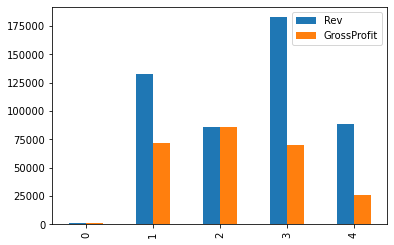

In [181]:
data = df_rev_profit[['Ticker','Rev','GrossProfit']]
data.plot.bar()

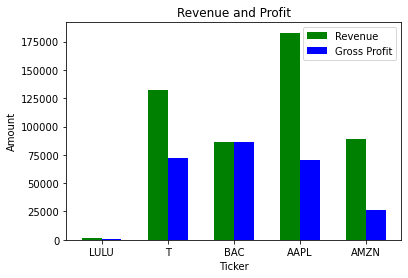

In [208]:
Year = df_rev_profit['Year']
Revenue = df_rev_profit['Rev']
GrossProfit = df_rev_profit['GrossProfit']
Ticker = df_rev_profit['Ticker']

index = np.arange(5)
width = 0.30

plt.bar(index,Revenue,width,color='green', label='Revenue')
plt.bar(index+width,GrossProfit,width,color='blue', label='Gross Profit')

plt.title('Revenue and Profit')
plt.ylabel('Amount')
plt.xlabel('Ticker')

plt.xticks(index + width/2,Ticker)

plt.legend(loc = 'best')
plt.show()

In [169]:
X

0     2014
1     2014
2     2014
3     2014
4     2014
5     2015
6     2015
7     2015
8     2015
9     2015
10    2016
11    2016
12    2016
13    2016
14    2016
15    2017
16    2017
17    2017
18    2017
19    2017
20    2018
21    2018
22    2018
23    2018
24    2018
Name: Year, dtype: object